### Recurrent network for time forecasting
In this project, we use a recurrent neural network (LSTM) to predict stock prices of Tesla using a dataset from [Yahoo finance](https://finance.yahoo.com/quote/TSLA/history?period1=1436486400&period2=1594339200&interval=1d&filter=history&frequency=1d).

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import keras
import math

In [2]:
from google.colab import files 
uploaded = files.upload()

Saving TSLA.csv to TSLA (16).csv


In order to predict future stock prices, we need to convert the problem into a supervised learning problem. From the dataset, we keep only the 'Close' column and the 'Date' column, which we set as index. We discard the rest of the columns. Next, we create two new columns; one holds the current stock price and the second holds the future stock price. For example, let's assume that we have the following 'Close' column:

 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Close

 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;a1

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a2

 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;a3


The new columns after the tranformation are the following:

X(t) &nbsp;&nbsp;   Y(t+1)
       
&nbsp;?  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;       a1
         
a1 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;       a2
       
a2 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;       a3

a3 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;       ?


Since we do not have any information about the first and the last rows of X and Y, we discard them.


In [3]:
def load_data_compile_fit():
  dataframe=pd.read_csv("TSLA.csv")
  # the output is the Close column
  dataframe = dataframe[['Date','Close']]
  print("Number of rows and columns: ", dataframe.shape)
  print(dataframe.head(5))
  dataframe.Date = pd.to_datetime(dataframe.Date).dt.date
  dataframe.set_index('Date', inplace=True)
  #data.plot(style="-")
  data = dataframe.values
  # train the normalization
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaler = scaler.fit(data)   
  # normalize the dataset
  data = scaler.transform(data)
  percentage_train_test = 0.6
  # observations are not independent, that's why we can not use sklearn.model_selection.train_test_split() 
  # split the dataset into train set and test set
  train_set_size = int(len(data)* percentage_train_test)
  test_set_size = int(len(data) - train_set_size)
  # define the content for each dataset
  train_set = data[:train_set_size]
  test_set = data[train_set_size:len(data)+1]
  # create a second column to use it as a future stock price
  X_train, X_test, y_train, y_test = future_stock_price_column(train_set, test_set)
  # LSTM requires input to have the format [samples, time steps, features], so we need to reshape our input data
  X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
  X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
  # define the model
  model = Sequential()
  model.add(LSTM(4, activation='relu', input_shape=(1, 1)))
  model.add(Dense(1))
  # config the model
  model.compile(optimizer='adam', loss='mse') 
  # train the model
  model.fit(X_train, y_train, epochs=150, batch_size=1, verbose=2)
  # prediction the stock prices
  y_train_prediction = model.predict(X_train)
  y_test_prediction = model.predict(X_test)
  # invert the predictions
  y_train_prediction = scaler.inverse_transform(y_train_prediction)
  y_train = scaler.inverse_transform([y_train])
  y_test_prediction = scaler.inverse_transform(y_test_prediction)
  y_test = scaler.inverse_transform([y_test])
  y = scaler.inverse_transform(data)
  # merge the train and test prediction to compare with the data later
  y_prediction = np.concatenate((y_train_prediction,y_test_prediction), axis=0)
  return y_train_prediction, y_train, y_test_prediction, y_test, y, y_prediction, dataframe

In [4]:
def future_stock_price_column(train_set, test_set):
  # the data is numpy arrays
  X_train = train_set.copy()
  X_test = test_set.copy()
  y_train = np.zeros(len(X_train))
  y_test = np.zeros(len(X_test))
  for i in range(len(train_set)-1):
    y_train[i] = train_set[i+1]
  for i in range(len(test_set)-1):
    y_test[i] = test_set[i+1]
  return X_train, X_test, y_train, y_test

In [5]:
def calculate_mse(y_train, y_train_prediction, y_test, y_test_prediction):
  train_score = math.sqrt(mean_squared_error(y_train[0], y_train_prediction[:,0]))
  test_score = math.sqrt(mean_squared_error(y_test[0], y_test_prediction[:,0]))
  return train_score, test_score

In [6]:
def plot(y,y_prediction, dataframe):
  plt.plot(dataframe.index, y, color = 'red', label='data')
  plt.plot(dataframe.index, y_prediction, color = 'blue', label='prediction',linestyle='dashed')
  plt.ylabel('USD')
  plt.xlabel('Year')
  plt.legend(loc="upper left")
  plt.show()

Number of rows and columns:  (1259, 2)
         Date      Close
0  2015-07-10  51.830002
1  2015-07-13  52.431999
2  2015-07-14  53.130001
3  2015-07-15  52.627998
4  2015-07-16  53.335999
Epoch 1/150
755/755 - 1s - loss: 0.0020
Epoch 2/150
755/755 - 1s - loss: 0.0010
Epoch 3/150
755/755 - 1s - loss: 4.4985e-04
Epoch 4/150
755/755 - 1s - loss: 1.3577e-04
Epoch 5/150
755/755 - 1s - loss: 6.7816e-05
Epoch 6/150
755/755 - 1s - loss: 6.3979e-05
Epoch 7/150
755/755 - 1s - loss: 6.3189e-05
Epoch 8/150
755/755 - 1s - loss: 6.2533e-05
Epoch 9/150
755/755 - 1s - loss: 6.6267e-05
Epoch 10/150
755/755 - 1s - loss: 6.3909e-05
Epoch 11/150
755/755 - 1s - loss: 6.4951e-05
Epoch 12/150
755/755 - 1s - loss: 6.4384e-05
Epoch 13/150
755/755 - 1s - loss: 6.5017e-05
Epoch 14/150
755/755 - 1s - loss: 6.3426e-05
Epoch 15/150
755/755 - 1s - loss: 6.2283e-05
Epoch 16/150
755/755 - 1s - loss: 6.3370e-05
Epoch 17/150
755/755 - 1s - loss: 6.3391e-05
Epoch 18/150
755/755 - 1s - loss: 6.5609e-05
Epoch 19/150
755/7

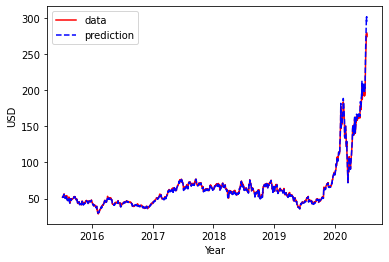

In [7]:
y_train_prediction, y_train, y_test_prediction, y_test, y, y_prediction, dataframe = load_data_compile_fit()
train_score, test_score = calculate_mse(y_train, y_train_prediction, y_test, y_test_prediction)
plot(y,y_prediction,dataframe)

### References

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

[Time-Series Forecasting: Predicting Stock Prices Using An LSTM Model](https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f)
